In [1]:
%matplotlib inline

In [2]:
# HIDDEN in jupyterbook 
#This is code to manage dependencies if the notebook is executed in the google colab cloud service
if 'google.colab' in str(get_ipython()):
  import os
  os.system('apt -qqq install graphviz')
  os.system('pip -qqq install ModelFlowIb ipysheet  --no-dependencies ')
  incolab = True  
else:
  incolab = False 

%load_ext autoreload
%autoreload 2

In [3]:
from modelclass import model 
import modelmf
model.widescreen()
model.scroll_off()

In [4]:
import modelmf

from modelinvert import targets_instruments
from modelclass import model


In [5]:
mpak,baseline = model.modelload('../../models/pak.pcim',alfa=0.7,run=1,ljit=0)

file read:  C:\modelflow manual\papers\mfbook\content\models\pak.pcim


In [6]:
for variable in ['PAKGGREVCO2CER', 'PAKGGREVCO2GER', 'PAKGGREVCO2OER', ]:
    print(variable,':',mpak.var_description[variable])
    

PAKGGREVCO2CER : Carbon tax on coal (USD/t)
PAKGGREVCO2GER : Carbon tax on gas (USD/t)
PAKGGREVCO2OER : Carbon tax on oil (USD/t)


In [7]:
target_var = ['PAKCCEMISCO2TKN']
instruments = [['PAKGGREVCO2CER','PAKGGREVCO2GER', 'PAKGGREVCO2OER']]

In [8]:
reduction_percent = 30   # Input the desired reduction 

In [9]:
bau_2100 =baseline.loc[2100,'PAKCCEMISCO2TKN']
bau_2022 = baseline.loc[2022,'PAKCCEMISCO2TKN']
bau_growth_rate = (bau_2100/bau_2022)**(1/(2100-2022))

target_2100 = baseline.loc[2100,'PAKCCEMISCO2TKN']*(1-reduction_percent/100)
target_growth_rate = (target_2100/bau_2022)**(1/(2100-2022))

print(f"Business as usual Emission value in 2100: {bau_2100:13,.0f}")
print(f"Business as usual Emission value in 2100: {target_2100:13,.0f}")
print(f"Business as usual growth rate in percent: {bau_growth_rate-1:13,.1%}")
print(f"Target growth rate in percent           : {target_growth_rate-1:13,.1%}")

Business as usual Emission value in 2100: 1,949,241,066
Business as usual Emission value in 2100: 1,364,468,747
Business as usual growth rate in percent:          2.8%
Target growth rate in percent           :          2.4%


In [10]:
target_before = baseline.loc[2022:,['PAKCCEMISCO2TKN']]     # Create dataframe with only the target variable 
# create a target dataframe with a projection of the target variable 
target = target_before.mfcalc(f'PAKCCEMISCO2TKN = PAKCCEMISCO2TKN(-1) * {target_growth_rate}',2023,2100 )

* Take care. Lags or leads in the equations, mfcalc run for 2023 to 2024


In [11]:
_ = mpak.invert(mpak.basedf,                  # Invert calls the target instrument device                   
                targets = target,                   
                instruments=instruments,
                DefaultImpuls=2,              # The default impulse instrument variables 
                defaultconv=2.0,              # Convergergence criteria for targets
                varimpulse=True,              # Only change the variable for current period
                nonlin=15,                    # If no convergence in 15 iteration recalculate jacobi 
                silent=1                      # Don't show iteration output (try 1 for showing)
                )

Finding instruments :   0%|          | 0/79

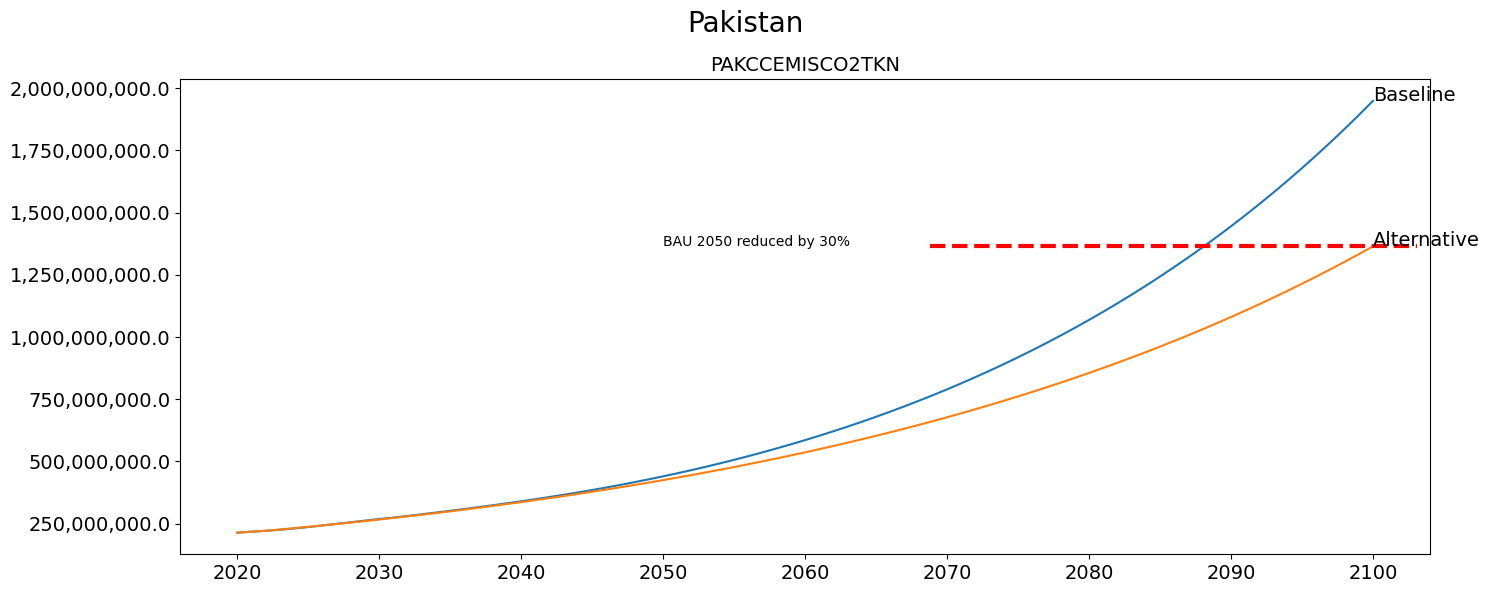

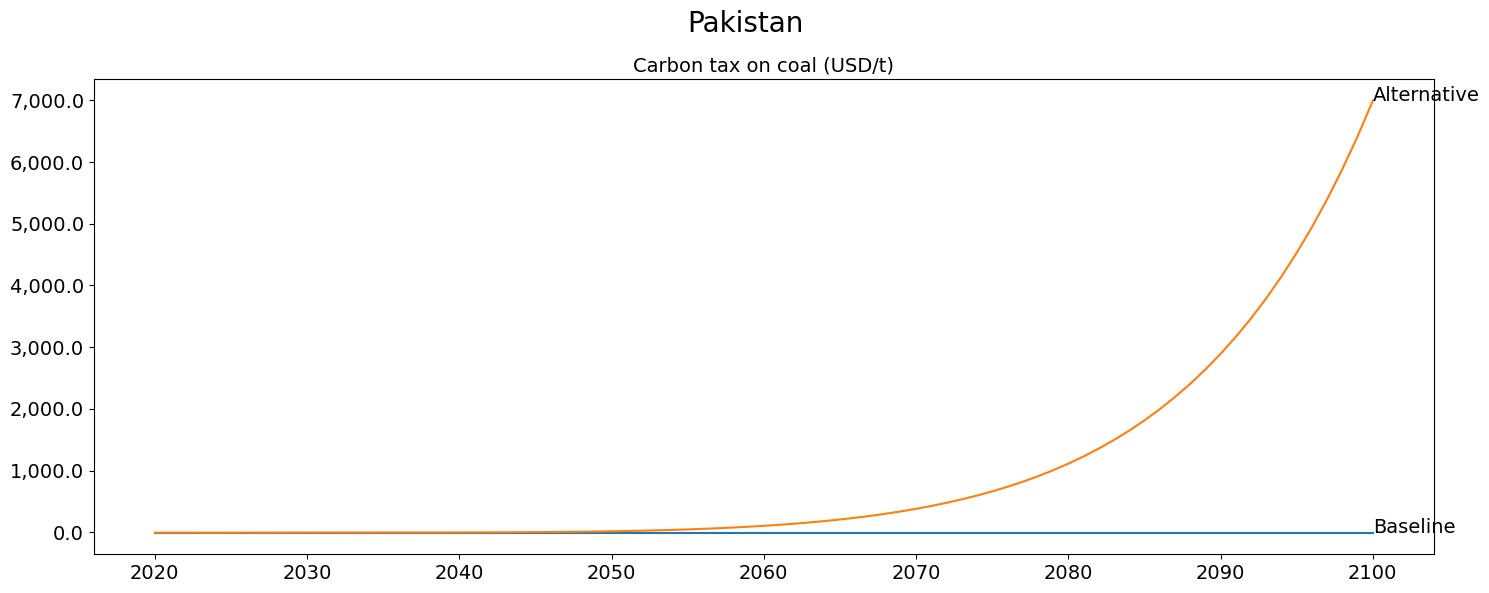

In [12]:
with mpak.set_smpl(2020,2100):    # change if you want another  timeframe 
    fig = mpak[f'PAKCCEMISCO2TKN' ].plot_alt(title='Pakistan')
    fig.axes[0].axhline( target_2100,
                                  xmin=0.6,
                                  xmax = 0.99,
                                  linewidth=3, 
                                  color='r', ls='dashed')

    fig.axes[0].annotate(f'BAU 2050 reduced by {reduction_percent}%', xy=(2050,target_2100 ))
    fig2 = mpak[f'PAKGGREVCO2CER' ].plot_alt(title=f'Pakistan'); 


In [13]:
mpak['PAKNYGDPMKTPKN PAKNECONGOVTKN PAKNEGDIFTOTKN PAKNEIMPGNFSKN PAKCCEMISCO2TKN']

In [14]:
new_instruments =[[('PAKGGREVCO2CER',10),
                   ('PAKGGREVCO2GER', 5),
                   ('PAKGGREVCO2OER',5)]]


_ = mpak.invert(mpak.basedf,targets = target,
                            instruments=new_instruments,
                          DefaultImpuls=1,
                                defaultconv=2.0,varimpulse=True,nonlin=15,silent=1)

Finding instruments :   0%|          | 0/79

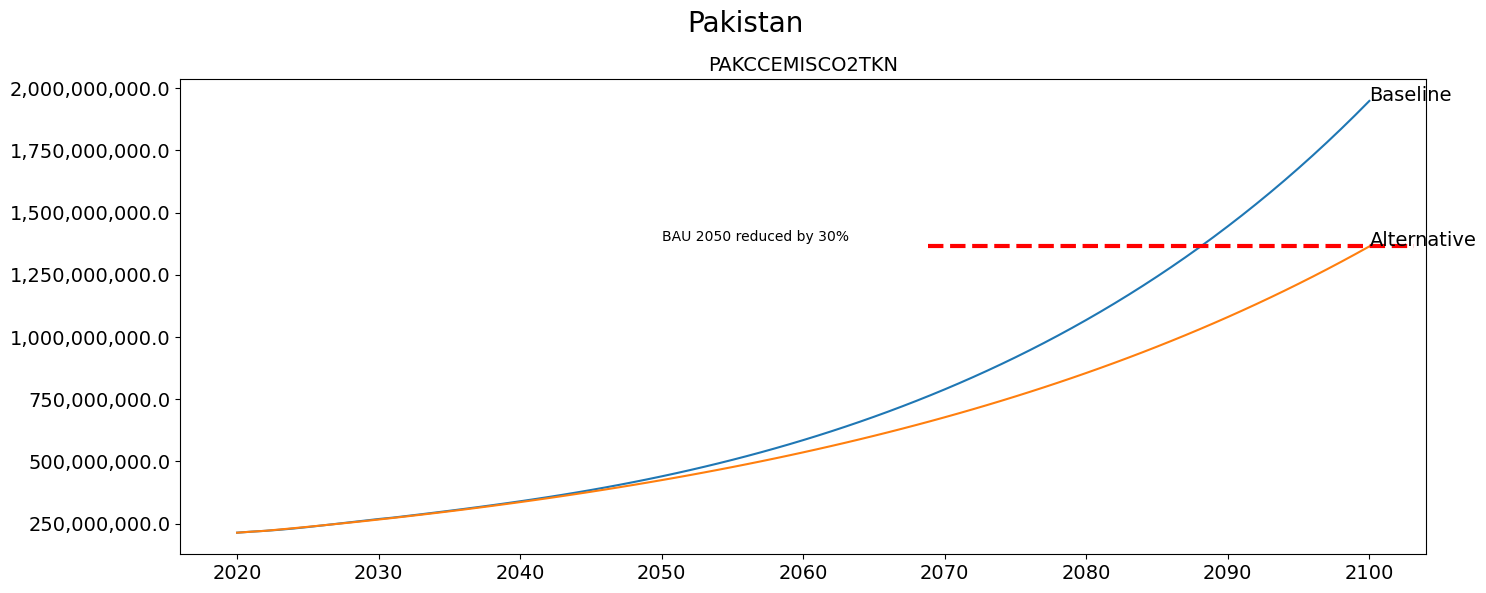

In [15]:
with mpak.set_smpl(2020,2100):    # change if you want another  timeframe 
    fig = mpak[f'PAKCCEMISCO2TKN' ].plot_alt(title='Pakistan')
    fig.axes[0].axhline( target_2100,
                                  xmin=0.6,
                                  xmax = 0.99,
                                  linewidth=3, 
                                  color='r', ls='dashed')

    fig.axes[0].annotate(f'BAU 2050 reduced by {reduction_percent}%', xy=(2050,target_2100*1.015 ))

In [16]:
    mpak['PAKGGREVCO2CER PAKGGREVCO2GER PAKGGREVCO2OER' ]

In [17]:
help(mpak.invert)

Help on method invert in module modelclass:

invert(databank, targets, instruments, silent=1, DefaultImpuls=0.01, defaultconv=0.001, nonlin=False, maxiter=30, delay=0, **kwargs) method of modelclass.model instance
    Solves instruments for targets



In [18]:
import modelinvert
help(modelinvert.targets_instruments)

Help on class targets_instruments in module modelinvert:

class targets_instruments(builtins.object)
 |  targets_instruments(databank, targets, instruments, model, DefaultImpuls=0.01, defaultconv=0.01, delay=0, nonlin=False, silent=True, maxiter=30, solveopt={}, varimpulse=False)
 |  
 |  Class to handle general target/instrument problems. 
 |  Where the response is delayed specify this with delay.
 |  
 |  Number of targets should be equal to number of instruments 
 |  
 |  An instrument can comprice of severeral variables
 |  
 |  **Instruments** are inputtet as a list of instruments
 |  
 |  To calculate the jacobian each instrument variable has a impuls, 
 |  which is used as delta when evaluating the jacobi matrix:: 
 |      
 |    [ 'QO_J','TG']   Simple list each variable are shocked by the default impulse 
 |    [ ('QO_J',0.5), 'TG']  Here QO_J is getting its own impuls (0.5)
 |    [ [('QO_J',0.5),('ORLOV',1.)] , ('TG',0.01)] here an impuls is given for each variable, and the f